# **Código para la implementación del modelo de Paridad de Riesgo Jerárquico (HRP)**



---



El contenido de este notebook corresponde a una compilación de algoritmos publicados en diferentes fuentes.

# **Instalación y cargue de librerías**

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.4 MB 7.2 MB/s 
     |████████████████████████████████| 62 kB 1.8 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.28.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [3]:
import scipy.cluster.hierarchy as sch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import cvxopt as opt
from cvxopt import blas, solvers
import yfinance as yf
import seaborn as sns
pd.options.display.float_format = '{:.4}'.format
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from numpy import linalg
from scipy.spatial.distance import pdist
import scipy.stats as scs

# ***Descarga de información***

In [4]:
#Características de los datos a descargar
# Date range
start = '2010-03-01'
end = '2021-12-31'
periodicidad = "1Mo"

# Tickers of assets
assets = ['AAPL','MSFT', 'JNJ','PFE','AMZN','WMT','MCO']
assets.sort()

#Descarga de información
data = yf.download(assets, start = start, end = end, interval=periodicidad)
data = data.loc[:,('Adj Close', slice(None))].dropna()
data.columns = assets

[*********************100%***********************]  7 of 7 completed


# ***Cálculo de rendimientos***

In [5]:
# Se obtienen los rendimientos
returns = np.log(data).diff()
returns = returns.dropna()
returns

,AAPL,AMZN,JNJ,MCO,MSFT,PFE,WMT
Date,,,,,,,
2010-04-01,0.1053,0.009748,-0.0139,-0.1852,0.04179,-0.02539,-0.03027
2010-05-01,-0.01626,-0.08872,-0.09796,-0.1872,-0.1687,-0.09334,-0.05913
2010-06-01,-0.02105,-0.1383,0.02204,-0.02382,-0.1099,-0.05532,-0.04471
2010-07-01,0.02249,0.07602,-0.01656,0.1674,0.1148,0.05059,0.06289
2010-08-01,-0.05658,0.0572,-0.01859,-0.108,-0.09504,0.0589,-0.02073
...,...,...,...,...,...,...,...
2021-08-01,0.04011,0.04213,0.005386,0.01261,0.05786,0.08241,0.03819
2021-09-01,-0.06896,-0.055,-0.06361,-0.06811,-0.06649,-0.06873,-0.05701
2021-10-01,0.057,0.02625,0.008509,0.1294,0.1624,0.01683,0.06956


# ***Estadísticas descriptivas***

Text(0, 0.5, 'Precio (USD)')

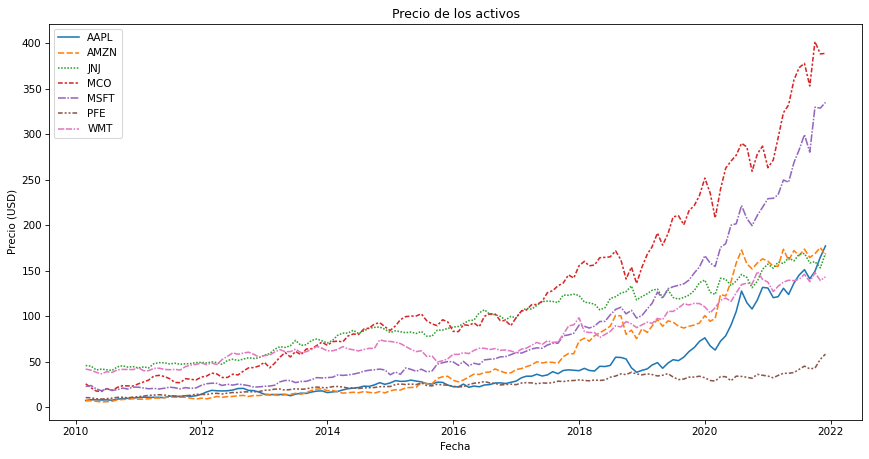

In [7]:
plt.figure(figsize=(14, 7), dpi=75)
sns.lineplot(data=data)
plt.title("Precio de los activos")
plt.xlabel("Fecha")
plt.ylabel("Precio (USD)")

In [8]:
cov = returns.cov()
cov

,AAPL,AMZN,JNJ,MCO,MSFT,PFE,WMT
AAPL,0.005754,0.002463,0.0009169,0.001934,0.002144,0.0007491,0.0007707
AMZN,0.002463,0.006175,0.001091,0.002513,0.002159,0.001412,0.0006468
JNJ,0.0009169,0.001091,0.001923,0.001227,0.0009682,0.001313,0.0009311
MCO,0.001934,0.002513,0.001227,0.005277,0.002026,0.001301,0.001007
MSFT,0.002144,0.002159,0.0009682,0.002026,0.003662,0.0006853,0.0006355
PFE,0.0007491,0.001412,0.001313,0.001301,0.0006853,0.003121,0.0008596
WMT,0.0007707,0.0006468,0.0009311,0.001007,0.0006355,0.0008596,0.002373


In [9]:
returns.describe()

,AAPL,AMZN,JNJ,MCO,MSFT,PFE,WMT
count,141.0,141.0,141.0,141.0,141.0,141.0,141.0
mean,0.02274,0.0227,0.009291,0.01933,0.01911,0.01224,0.008744
std,0.07586,0.07858,0.04385,0.07264,0.06052,0.05586,0.04872
min,-0.2034,-0.2259,-0.1232,-0.1872,-0.1687,-0.1453,-0.1692
25%,-0.02039,-0.03331,-0.01656,-0.02382,-0.01314,-0.02503,-0.02207
50%,0.02833,0.02579,0.01093,0.02497,0.02225,0.01134,0.009065
75%,0.07362,0.07258,0.03523,0.07847,0.05436,0.04985,0.04286
max,0.1942,0.2382,0.1347,0.1716,0.1792,0.2057,0.1378


In [10]:
print('Jarque-Bera statistic: {stat:.2f} with p-value: {p_val:.2f}'.format(stat =
scs.jarque_bera(returns['WMT'].values)[0],
p_val = scs.jarque_bera(returns['WMT'].values)[1]))

Jarque-Bera statistic: 4.52 with p-value: 0.10


# ***Modelo HRP: Funciones para la implementación de sus 3 partes***

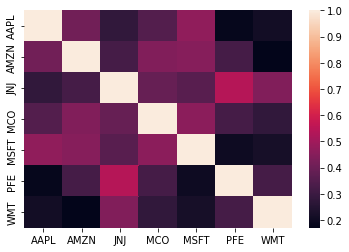

In [11]:
#Obtención de la matriz de correlación de los retornos.
corr = returns.corr().round(2) # round to 2 decimal places
fig_corr = px.imshow(corr, text_auto=True, title = 'Correlación entre los activos')
fig_corr.show()
sns.heatmap(corr)

In [12]:
def correlDist(corr):
    # A distance matrix based on correlation, where 0<=d[i,j]<=1
    # This is a proper distance metric
    dist = ((1 - corr) / 2.)**.5  # distance matrix
    return dist

In [13]:
#Calculate linkage
dist = correlDist(returns.corr())
link = linkage(dist, 'single')

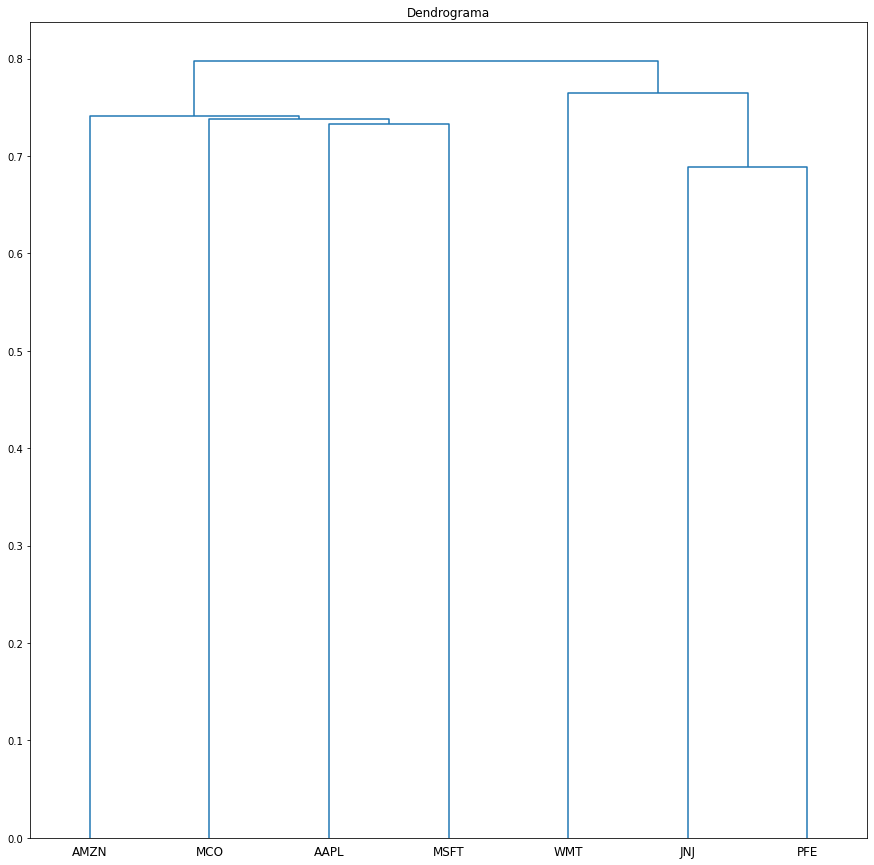

In [14]:
#Plot Dendrogram
plt.figure(figsize=(15, 15))
plt.title("Dendrograma")
dendrogram(link, labels = returns.columns)
plt.show()

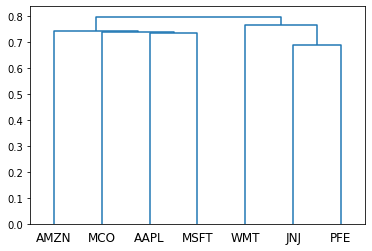

In [15]:
dn = sch.dendrogram(link, labels=returns.columns)
plt.show()

In [16]:
def getIVP(cov, **kargs):
    # Compute the inverse-variance portfolio
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp

In [17]:
def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]  # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
        df0 = sortIx[sortIx >= numItems]  # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = sortIx.append(df0)  # item 2
        sortIx = sortIx.sort_index()  # re-sort
        sortIx.index = range(sortIx.shape[0])  # re-index
    return sortIx.tolist()

In [39]:
sortIx = getQuasiDiag(link)
sortIx = corr.index[sortIx].tolist() # recover labels
print("sortix", sortIx)
df0 = corr.loc[sortIx, sortIx] # reorder        #Matrice di correlazioni tra clusters

sortix ['AMZN', 'MCO', 'AAPL', 'MSFT', 'WMT', 'JNJ', 'PFE']


In [19]:
def getClusterVar(cov,cItems):
    # Compute variance per cluster
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar

In [20]:
def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx]  # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]  # bi-section
        for i in range(0, len(cItems), 2):  # parse in pairs
            cItems0 = cItems[i]  # cluster 1
            cItems1 = cItems[i + 1]  # cluster 2
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha  # weight 1
            w[cItems1] *= 1 - alpha  # weight 2
    return w

# ***Pesos óptimos HRP y MVP***

In [21]:
def getHRP(cov, corr):
    # Construct a hierarchical portfolio
    dist = correlDist(corr)
    link = sch.linkage(dist, 'single')
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist()
    hrp = getRecBipart(cov, sortIx)
    hrp = pd.Series(hrp, index = assets, name="HRP")
    return hrp.sort_index()

In [22]:
def getMVP(cov):

    cov = cov.T.values
    n = len(cov)
    N = 100
    mus = [10 ** (5.0 * t / N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(cov)
    #pbar = opt.matrix(np.mean(returns, axis=1))
    pbar = opt.matrix(np.ones(cov.shape[0]))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))  # negative n x n identity matrix
    h = opt.matrix(0.0, (n, 1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)

    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu * S, -pbar, G, h, A, b)['x']
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S * x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    wt = pd.Series(wt, index = assets, name="MVP")

    return list(wt)

In [23]:
def get_all_portfolios(returns):
    
    cov, corr = returns.cov(), returns.corr()
    hrp = getHRP(cov, corr)
    mvp = getMVP(cov)
    mvp = pd.Series(mvp, index=cov.index)
    
    portfolios = pd.DataFrame([hrp,mvp], index=['HRP','MVP']).T
    
    return portfolios

In [24]:
#Pesos portafolio HRP y MV
portfolios = get_all_portfolios(returns)
portfolios

     pcost       dcost       gap    pres   dres
 0: -9.9991e-01 -2.0000e+00  1e+00  1e-15  1e+00
 1: -9.9991e-01 -1.0100e+00  1e-02  6e-17  1e-02
 2: -9.9991e-01 -1.0001e+00  2e-04  8e-17  2e-04
 3: -9.9993e-01 -9.9996e-01  3e-05  2e-16  2e-05
 4: -9.9993e-01 -9.9994e-01  4e-06  8e-17  6e-17
 5: -9.9993e-01 -9.9993e-01  3e-07  7e-17  5e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -9.9990e-01 -2.0000e+00  1e+00  2e-15  1e+00
 1: -9.9990e-01 -1.0100e+00  1e-02  6e-17  1e-02
 2: -9.9990e-01 -1.0001e+00  2e-04  9e-17  2e-04
 3: -9.9992e-01 -9.9995e-01  3e-05  8e-17  2e-05
 4: -9.9993e-01 -9.9993e-01  4e-06  7e-17  7e-17
 5: -9.9993e-01 -9.9993e-01  4e-07  6e-17  8e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -9.9989e-01 -2.0000e+00  1e+00  0e+00  1e+00
 1: -9.9989e-01 -1.0100e+00  1e-02  1e-16  1e-02
 2: -9.9989e-01 -1.0001e+00  2e-04  2e-16  2e-04
 3: -9.9991e-01 -9.9994e-01  3e-05  5e-17  2e-05
 4: -9.9992e-01 -9.9992e

,HRP,MVP
AAPL,0.08387,0.05267
AMZN,0.1056,0.01554
JNJ,0.2183,0.3207
MCO,0.09146,0.001706
MSFT,0.144,0.1513
PFE,0.1345,0.1463
WMT,0.2222,0.3118


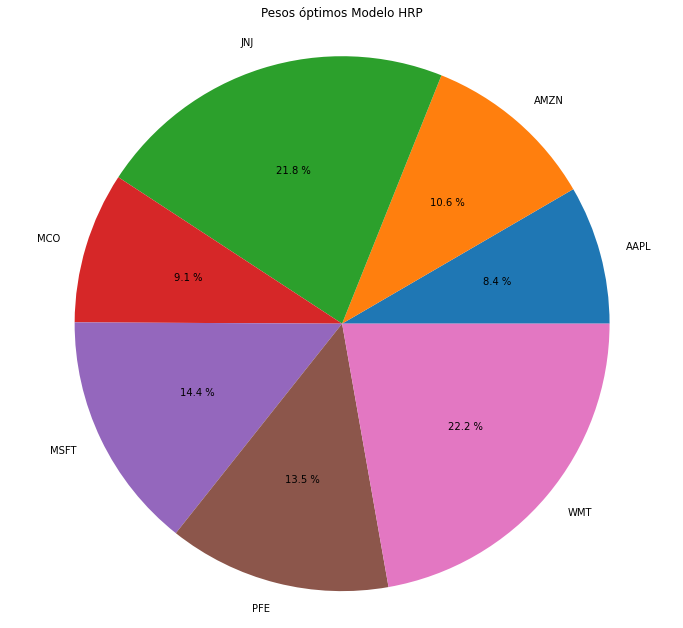

In [50]:
plt.figure(figsize=(12, 11))
plt.pie(portfolios['HRP'], labels=assets, autopct="%0.1f %%")
plt.axis("equal")
plt.title('Pesos óptimos Modelo HRP')
plt.show()

# ***Pesos óptimos modelo Risk Parity (RP)***

In [27]:
def compute_RP_weights(cov):
  weights = (1 / np.diag(cov))
  xrp = weights / sum(weights)
  xrp = pd.Series(xrp, index = assets, name="RP")
  return xrp

In [28]:
xrp = compute_RP_weights(cov)
xrp

AAPL   0.08436
AMZN   0.07861
JNJ     0.2524
MCO    0.09199
MSFT    0.1325
PFE     0.1556
WMT     0.2045
Name: RP, dtype: float64

# ***Consoliación de pesos óptimos. Modelos: HRP, MV y RP***

In [29]:
#Consolidación pesos óptimos
weights_HRP = getHRP(cov, corr)
weights_RP = compute_RP_weights(cov)

results = weights_HRP.to_frame()
results = results.join(portfolios['MVP'].to_frame())
results = results.join(weights_RP.to_frame())
results

,HRP,MVP,RP
AAPL,0.08387,0.05267,0.08436
AMZN,0.1056,0.01554,0.07861
JNJ,0.2183,0.3207,0.2524
MCO,0.09146,0.001706,0.09199
MSFT,0.144,0.1513,0.1325
PFE,0.1345,0.1463,0.1556
WMT,0.2222,0.3118,0.2045


# ***Retorno esperado***

In [30]:
def compute_ER(weights):
  mean = returns.mean(0)
  return weights.values * mean

In [31]:
#sin cortos MVP
er_hrp = compute_ER(weights_HRP)
er_hrp.name = "HRP"
er_mv = compute_ER(portfolios['MVP'])
er_mv.name = "MV"
er_rp = compute_ER(weights_RP)
er_rp.name = "RP"

ers = er_hrp.to_frame()
ers = ers.join(er_mv.to_frame())
ers = ers.join(er_rp.to_frame())
ers = ers.sum()
ers.name = "Expected Return"
ers = ers.to_frame()

ers

,Expected Return
HRP,0.01444
MV,0.01197
RP,0.01405


# ***Volatilidad***

In [32]:
def portfolio_volatility(weights, cov):
  return np.sqrt(np.dot(np.dot(weights.values, cov.values), weights.values))

In [33]:
datos = [portfolio_volatility(weights_HRP, cov)]
datos.append(portfolio_volatility(portfolios['MVP'], cov))
datos.append(portfolio_volatility(weights_RP, cov))
volatility = pd.DataFrame(data = datos, index=["HRP", "MV", "RP"],
columns=["Volatility"])
volatility

,Volatility
HRP,0.03816
MV,0.03624
RP,0.03774


# ***Ratio de Sharpe***

In [34]:
#Ratio de Sharpe
def sharpe_ratio(weights, cov):
  ret_portfolio = compute_ER(weights).sum()
  ret_free = 0
  volatility = portfolio_volatility(weights, cov)
  return (ret_portfolio - ret_free)/volatility

In [35]:
datos = [sharpe_ratio(weights_HRP, cov)]
datos.append(sharpe_ratio(portfolios['MVP'], cov))
datos.append(sharpe_ratio(weights_RP, cov))
sharpe_R= pd.DataFrame(data = datos, index=["HRP", "MV", "RP"],
columns=["Sharpe Ratio"])
sharpe_R

,Sharpe Ratio
HRP,0.3784
MV,0.3304
RP,0.3723


# ***Ratio de Diversificación***

In [36]:
#Ratio de Diversificación
def diversification_ratio(weights, cov):
  p_volatility = portfolio_volatility(weights, cov)
  return np.dot(np.sqrt(np.diag(cov.values)), weights) / p_volatility

In [37]:
dat = [diversification_ratio(weights_HRP, cov)]
dat.append(diversification_ratio(portfolios['MVP'], cov))
dat.append(diversification_ratio(weights_RP, cov))
dr = pd.DataFrame(data = dat, index=["HRP", "MV", "RP"], columns = ["Div Ratio"])

# ***Resultados consolidados***

In [38]:
#Resultados consolidados
final_results = ers.join(volatility)
final_results = final_results.join(sharpe_R)
final_results = final_results.join(dr)
final_results

,Expected Return,Volatility,Sharpe Ratio,Div Ratio
HRP,0.01444,0.03816,0.3784,1.518
MV,0.01197,0.03624,0.3304,1.433
RP,0.01405,0.03774,0.3723,1.51
